In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [1]:
def graph_moments(G):
    A = nx.to_scipy_sparse_array(G, format="csr")
    deg = np.asarray(A.sum(axis=1)).reshape(-1)
    return A, float(deg.mean()), float((deg**2).mean())


def simulate_sis(
    G,
    beta,
    gamma,
    i0=0.01,
    T=300,
    seed=42,
    A_cached=None
):
    rng = np.random.default_rng(seed)
    N = G.number_of_nodes()

    if A_cached is None:
        A, k_mean, k2_mean = graph_moments(G)
    else:
        A = A_cached
        deg = np.asarray(A.sum(axis=1)).reshape(-1)
        k_mean = float(deg.mean())
        k2_mean = float((deg**2).mean())

    state = np.zeros(N, dtype=np.int8)
    n0 = max(1, int(i0 * N))
    state[rng.choice(N, size=n0, replace=False)] = 1

    infected_frac = np.zeros(T + 1)
    infected_frac[0] = state.mean()

    for t in range(1, T + 1):
        infected = state == 1
        susceptible = ~infected

        m = np.asarray(A @ infected.astype(np.int8)).reshape(-1)
        p_inf = 1.0 - (1.0 - beta) ** m

        new_state = state.copy()

        r1 = rng.random(N)
        new_state[susceptible & (r1 < p_inf)] = 1

        r2 = rng.random(N)
        new_state[infected & (r2 < gamma)] = 0

        state = new_state
        infected_frac[t] = state.mean()

    return infected_frac, k_mean, k2_mean


def endemic_level_from_series(infected_frac, T, tail=0.2):
    return infected_frac[int((1 - tail) * T):].mean()


def mean_field_threshold_er(k_mean):
    return 1.0 / k_mean


def mean_field_endemic_er(beta, gamma, k_mean):
    lam = beta / gamma
    return max(0.0, 1.0 - 1.0 / (lam * k_mean))


def lambda_c_scale_free(k_mean, k2_mean):
    return k_mean / k2_mean


def make_er_graph(N, p, seed=0):
    return nx.erdos_renyi_graph(N, p, seed=seed)


def make_ba_graph(N, m, seed=0):
    return nx.barabasi_albert_graph(N, m, seed=seed)

In [5]:
def graph_moments(G):
    A = nx.to_scipy_sparse_array(G, format="csr")
    deg = np.asarray(A.sum(axis=1)).reshape(-1)
    return A, float(deg.mean()), float((deg**2).mean())


def simulate_sis(G, beta, gamma, i0=0.01, T=300, seed=42, A_cached=None):
    rng = np.random.default_rng(seed)
    N = G.number_of_nodes()

    if A_cached is None:
        A, k_mean, k2_mean = graph_moments(G)
    else:
        A = A_cached
        deg = np.asarray(A.sum(axis=1)).reshape(-1)
        k_mean = float(deg.mean())
        k2_mean = float((deg**2).mean())

    state = np.zeros(N, dtype=np.int8)
    n0 = max(1, int(i0 * N))
    state[rng.choice(N, size=n0, replace=False)] = 1

    infected_frac = np.zeros(T + 1)
    infected_frac[0] = state.mean()

    for t in range(1, T + 1):
        infected = state == 1
        susceptible = ~infected

        m = np.asarray(A @ infected.astype(np.int8)).reshape(-1)
        p_inf = 1.0 - (1.0 - beta) ** m

        new_state = state.copy()

        r1 = rng.random(N)
        new_state[susceptible & (r1 < p_inf)] = 1

        r2 = rng.random(N)
        new_state[infected & (r2 < gamma)] = 0

        state = new_state
        infected_frac[t] = state.mean()

    return infected_frac, k_mean, k2_mean


def endemic_level_from_series(infected_frac, T, tail=0.2):
    return infected_frac[int((1 - tail) * T):].mean()


def mean_field_threshold_er(k_mean):
    return 1.0 / k_mean


def mean_field_endemic_er(beta, gamma, k_mean):
    lam = beta / gamma
    return max(0.0, 1.0 - 1.0 / (lam * k_mean))


def lambda_c_scale_free(k_mean, k2_mean):
    return k_mean / k2_mean


def make_er_graph(N, p, seed=0):
    return nx.erdos_renyi_graph(N, p, seed=seed)


def make_ba_graph(N, m, seed=0):
    return nx.barabasi_albert_graph(N, m, seed=seed)


def plot_time_series(G, A, betas, gamma, i0, T, seed, title, threshold_lam=None, mf_line_fn=None, fmt_beta="{:.4f}"):
    plt.figure(figsize=(10, 5))

    for beta in betas:
        infected_frac, k_mean, k2_mean = simulate_sis(G, beta, gamma, i0=i0, T=T, seed=seed, A_cached=A)
        lam = beta / gamma
        i_inf_sim = endemic_level_from_series(infected_frac, T, tail=0.2)

        parts = [f"β={fmt_beta.format(beta)}", f"λ={lam:.3f}"]
        if threshold_lam is not None:
            parts.append(f"λc≈{threshold_lam:.3f}")
        parts.append(f"i∞SIM≈{i_inf_sim:.3f}")
        label = ", ".join(parts)

        plt.plot(infected_frac, label=label)

        if mf_line_fn is not None:
            i_inf_mf = mf_line_fn(beta, k_mean, k2_mean)
            plt.axhline(i_inf_mf, linestyle="--")

    plt.xlabel("Time step t")
    plt.ylabel("i(t) = I(t) / N")
    plt.title(title)
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()


def plot_endemic_curve(lams, i_sim, title, lam_c=None, extra_label=None):
    plt.figure(figsize=(7, 5))
    plt.plot(lams, i_sim, "o-", label="simulation (avg)")
    if lam_c is not None:
        if extra_label is None:
            extra_label = f"λc≈{lam_c:.5f}"
        plt.axvline(lam_c, linestyle=":", label=extra_label)
    plt.xlabel("λ = β / γ")
    plt.ylabel("i∞ (simulation)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


def sweep_lambda(G, A, gamma, i0, T, lams, trials=5, seed0=1000):
    i_inf = []
    for lam in lams:
        beta = lam * gamma
        vals = []
        for tr in range(trials):
            infected_frac, _, _ = simulate_sis(G, beta, gamma, i0=i0, T=T, seed=seed0 + 17 * tr, A_cached=A)
            vals.append(endemic_level_from_series(infected_frac, T, tail=0.2))
        i_inf.append(float(np.mean(vals)))
    return i_inf

### Infection probability in the SIS simulation

For each node we compute the number of infected neighbors
$ m_i = \sum_{j \in N(i)} \mathbf{1}_{\{j \text{ is infected}\}} $.
Assuming independent transmission with probability $\beta$ from each infected neighbor, the probability that node $i$ becomes infected in a single time step is
$ p_{\text{inf}}(i) = 1 - (1 - \beta)^{m_i} $,
which represents the probability that at least one infected neighbor transmits the infection.



# P11.1
Implement simulation of SIS model on ER graph. Compare
results with our analytical findings. [2P]


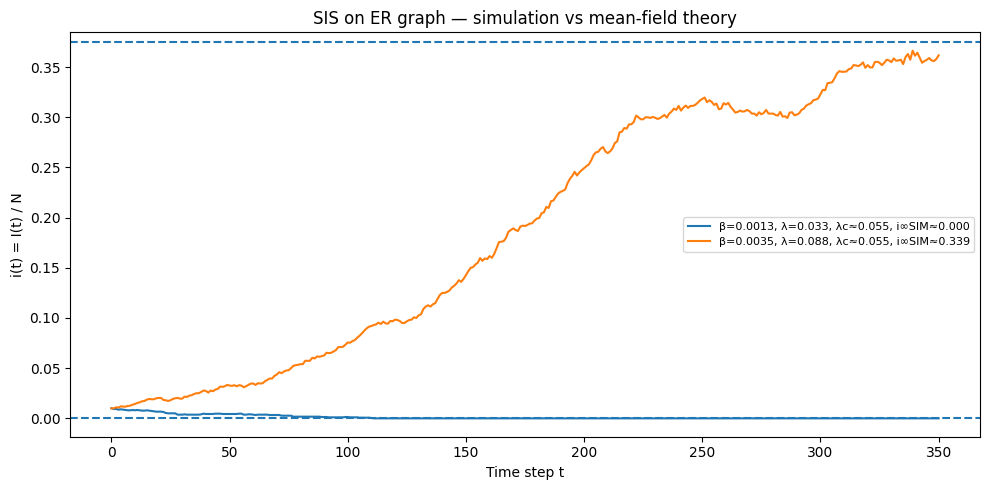

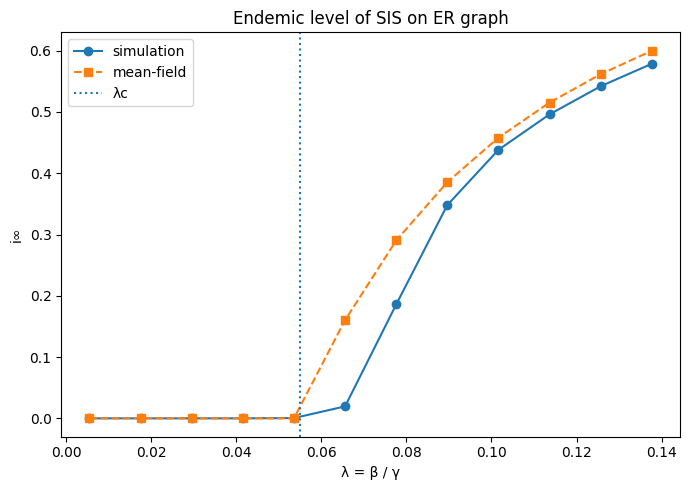

N= 1000: <k>=5.982, <k^2>=80.602, λc≈0.074217
N= 2000: <k>=5.991, <k^2>=88.787, λc≈0.067476
N= 4000: <k>=5.995, <k^2>=96.800, λc≈0.061937
N= 8000: <k>=5.998, <k^2>=105.843, λc≈0.056667


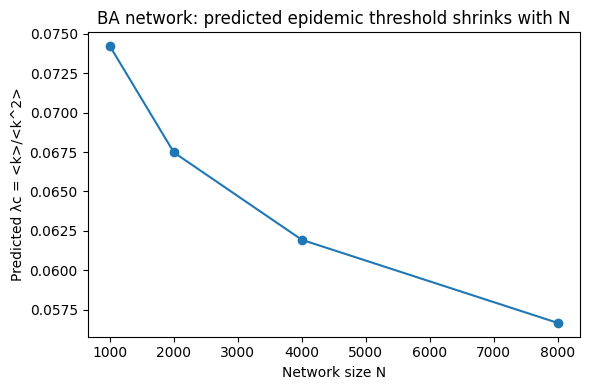

In [8]:
N = 3000
p = 0.006
gamma = 0.04
i0 = 0.01
T = 350
seed = 7

G = make_er_graph(N, p, seed=seed)
A, k_mean, k2_mean = graph_moments(G)

lam_c_er = mean_field_threshold_er(k_mean)
beta_c_er = lam_c_er * gamma

betas = [0.6 * beta_c_er, 1.6 * beta_c_er]

def mf_er_line(beta, k_mean, k2_mean):
    return mean_field_endemic_er(beta, gamma, k_mean)

plot_time_series(
    G, A, betas, gamma, i0, T, seed,
    title="SIS on ER graph — simulation vs mean-field theory",
    threshold_lam=lam_c_er,
    mf_line_fn=mf_er_line,
    fmt_beta="{:.4f}"
)

betas_sweep = np.linspace(0.1 * beta_c_er, 2.5 * beta_c_er, 12)
lams_sweep = betas_sweep / gamma

i_sim = []
i_mf = []
for beta in betas_sweep:
    infected_frac, k_mean, _ = simulate_sis(G, beta, gamma, i0=i0, T=T, seed=seed, A_cached=A)
    i_sim.append(endemic_level_from_series(infected_frac, T, tail=0.2))
    i_mf.append(mean_field_endemic_er(beta, gamma, k_mean))

plt.figure(figsize=(7, 5))
plt.plot(lams_sweep, i_sim, "o-", label="simulation")
plt.plot(lams_sweep, i_mf, "s--", label="mean-field")
plt.axvline(lam_c_er, linestyle=":", label="λc")
plt.xlabel("λ = β / γ")
plt.ylabel("i∞")
plt.title("Endemic level of SIS on ER graph")
plt.legend()
plt.tight_layout()
plt.show()

Ns = [1000, 2000, 4000, 8000]
m = 3

lamc_list = []
for Nn in Ns:
    G_tmp = make_ba_graph(Nn, m, seed=123)
    _, k_mean, k2_mean = graph_moments(G_tmp)
    lamc_list.append(lambda_c_scale_free(k_mean, k2_mean))
    print(f"N={Nn:5d}: <k>={k_mean:.3f}, <k^2>={k2_mean:.3f}, λc≈{lamc_list[-1]:.6f}")

plt.figure(figsize=(6, 4))
plt.plot(Ns, lamc_list, "o-")
plt.xlabel("Network size N")
plt.ylabel("Predicted λc = <k>/<k^2>")
plt.title("BA network: predicted epidemic threshold shrinks with N")
plt.tight_layout()
plt.show()



# P11.2
 Implement simulation of SIS model on BA networks. Compare
results with our analytical findings. [2P]


<k> ≈ 5.994, <k^2> ≈ 99.228
Predicted λc = <k>/<k^2> ≈ 0.06041
Predicted βc = λc * γ ≈ 0.00242


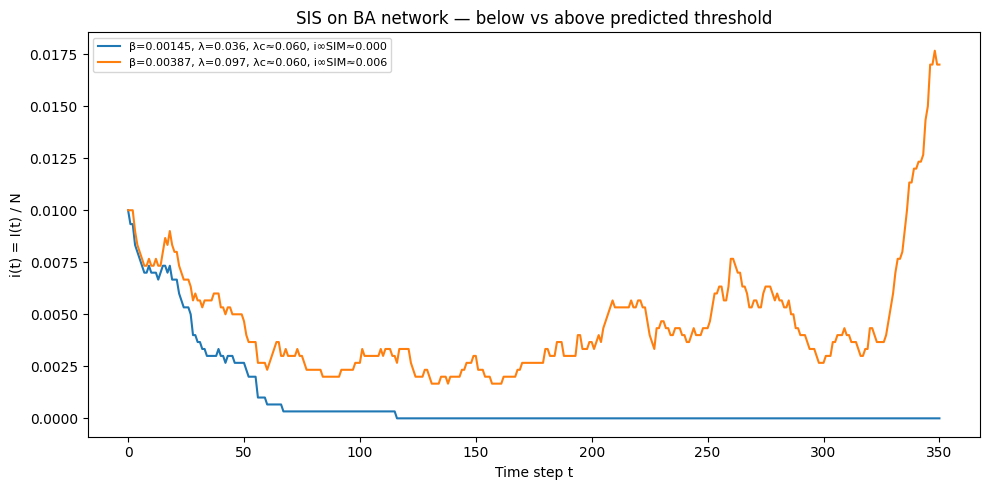

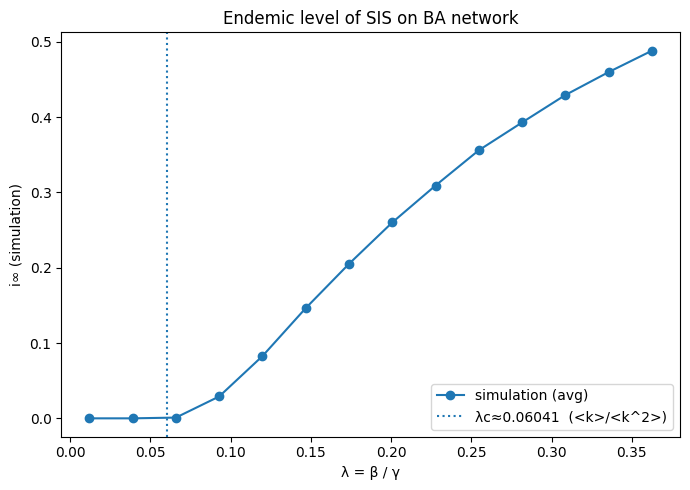

In [7]:
N = 3000
m = 3
gamma = 0.04
i0 = 0.01
T = 350
seed = 7

G = make_ba_graph(N, m, seed=10)
A, k_mean, k2_mean = graph_moments(G)

lam_c_ba = lambda_c_scale_free(k_mean, k2_mean)
beta_c_ba = lam_c_ba * gamma

print(f"<k> ≈ {k_mean:.3f}, <k^2> ≈ {k2_mean:.3f}")
print(f"Predicted λc = <k>/<k^2> ≈ {lam_c_ba:.5f}")
print(f"Predicted βc = λc * γ ≈ {beta_c_ba:.5f}")

betas = [0.6 * beta_c_ba, 1.6 * beta_c_ba]

plot_time_series(
    G, A, betas, gamma, i0, T, seed,
    title="SIS on BA network — below vs above predicted threshold",
    threshold_lam=lam_c_ba,
    mf_line_fn=None,
    fmt_beta="{:.5f}"
)

lams = np.linspace(0.2 * lam_c_ba, 6.0 * lam_c_ba, 14)
i_inf_sim = sweep_lambda(G, A, gamma, i0, T, lams, trials=5, seed0=1000)

plot_endemic_curve(
    lams, i_inf_sim,
    title="Endemic level of SIS on BA network",
    lam_c=lam_c_ba,
    extra_label=f"λc≈{lam_c_ba:.5f}  (<k>/<k^2>)"
)


# P11.3
 Implement simulation of different than SIS agent-based model.
Discuss obtained results.

ER: consensus time = None
BA: consensus time = None


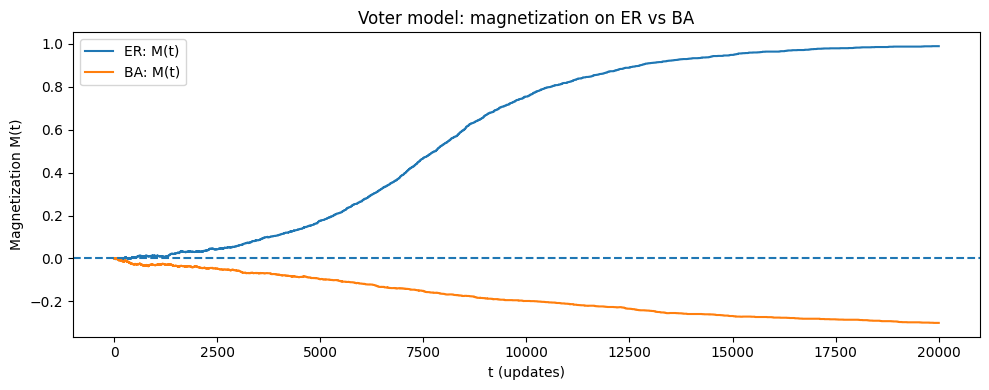

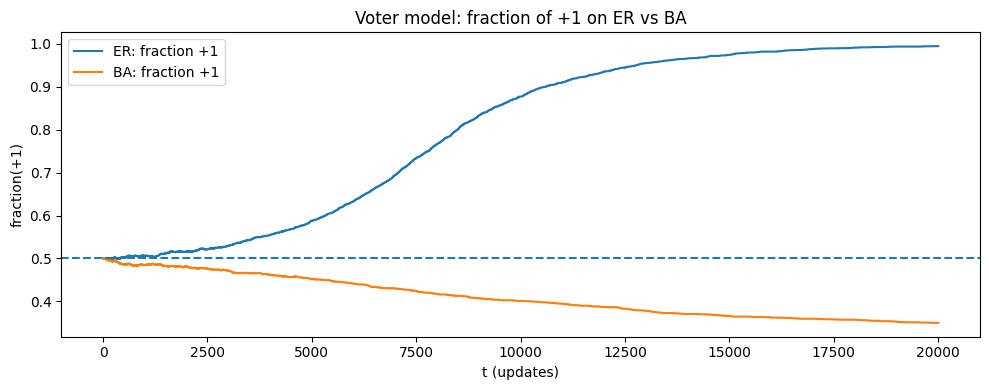

ER: mean consensus time (capped at T2) = 32274.8
BA: mean consensus time (capped at T2) = 49206.4


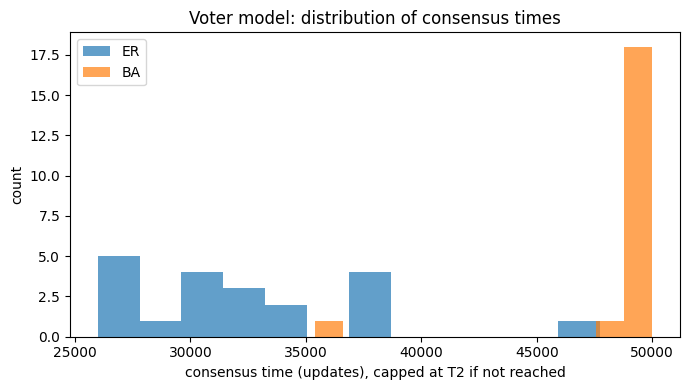

In [21]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def simulate_voter_model(
    G,
    T=20000,
    init_plus_frac=0.5,
    update_mode="async",
    tie_rule="keep",
    seed=42,
    return_states=False
):
    rng = np.random.default_rng(seed)

    N = G.number_of_nodes()
    nodes = np.array(list(G.nodes()))
    node_to_idx = {u: i for i, u in enumerate(nodes)}

    neigh = [np.array([node_to_idx[v] for v in G.neighbors(u)], dtype=int) for u in nodes]

    state = np.full(N, -1, dtype=np.int8)
    n_plus = max(1, int(round(init_plus_frac * N)))
    plus_idx = rng.choice(N, size=n_plus, replace=False)
    state[plus_idx] = 1

    def magnetization(x):
        return x.mean()

    steps = T
    M = np.empty(steps + 1, dtype=float)
    frac_plus = np.empty(steps + 1, dtype=float)

    M[0] = magnetization(state)
    frac_plus[0] = (state == 1).mean()

    def is_consensus(x):
        s = x.sum()
        return (s == N) or (s == -N)

    t_consensus = 0 if is_consensus(state) else None

    if update_mode not in {"async", "sweep"}:
        raise ValueError("update_mode must be 'async' or 'sweep'")

    t = 0
    for step in range(1, steps + 1):
        if update_mode == "async":
            i = rng.integers(0, N)
            nb = neigh[i]
            if nb.size > 0:
                m = int(state[nb].sum())
                if m > 0:
                    state[i] = 1
                elif m < 0:
                    state[i] = -1
                else:
                    if tie_rule == "random":
                        state[i] = 1 if rng.random() < 0.5 else -1
                    elif tie_rule == "keep":
                        pass
                    else:
                        raise ValueError("tie_rule must be 'keep' or 'random'")

            t = step

        else:
            for _ in range(N):
                i = rng.integers(0, N)
                nb = neigh[i]
                if nb.size > 0:
                    m = int(state[nb].sum())
                    if m > 0:
                        state[i] = 1
                    elif m < 0:
                        state[i] = -1
                    else:
                        if tie_rule == "random":
                            state[i] = 1 if rng.random() < 0.5 else -1
                        elif tie_rule == "keep":
                            pass
                        else:
                            raise ValueError("tie_rule must be 'keep' or 'random'")
            t = step

        M[step] = magnetization(state)
        frac_plus[step] = (state == 1).mean()

        if t_consensus is None and is_consensus(state):
            t_consensus = t

    if return_states:
        return M, frac_plus, t_consensus, state
    return M, frac_plus, t_consensus


def make_er_graph(N=2000, p=0.01, seed=1):
    return nx.erdos_renyi_graph(N, p, seed=seed)

def make_ba_graph(N=2000, m=3, seed=1):
    return nx.barabasi_albert_graph(N, m, seed=seed)


if __name__ == "__main__":
    N = 3000
    T = 20000
    init_plus_frac = 0.5
    seed = 7

    G_er = make_er_graph(N=N, p=0.006, seed=10)
    G_ba = make_ba_graph(N=N, m=3, seed=10)

    M_er, f_er, tC_er = simulate_voter_model(
        G_er, T=T, init_plus_frac=init_plus_frac, update_mode="async", tie_rule="keep", seed=seed
    )
    M_ba, f_ba, tC_ba = simulate_voter_model(
        G_ba, T=T, init_plus_frac=init_plus_frac, update_mode="async", tie_rule="keep", seed=seed
    )

    print(f"ER: consensus time = {tC_er}")
    print(f"BA: consensus time = {tC_ba}")

    plt.figure(figsize=(10, 4))
    plt.plot(M_er, label="ER: M(t)")
    plt.plot(M_ba, label="BA: M(t)")
    plt.axhline(0.0, linestyle="--")
    plt.xlabel("t (updates)")
    plt.ylabel("Magnetization M(t)")
    plt.title("Voter model: magnetization on ER vs BA")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(f_er, label="ER: fraction +1")
    plt.plot(f_ba, label="BA: fraction +1")
    plt.axhline(0.5, linestyle="--")
    plt.xlabel("t (updates)")
    plt.ylabel("fraction(+1)")
    plt.title("Voter model: fraction of +1 on ER vs BA")
    plt.legend()
    plt.tight_layout()
    plt.show()

    trials = 20
    T2 = 50000

    cons_er = []
    cons_ba = []

    for tr in range(trials):
        s = 1000 + 17 * tr
        _, _, tC = simulate_voter_model(G_er, T=T2, init_plus_frac=0.5, seed=s)
        cons_er.append(T2 if tC is None else tC)

        _, _, tC = simulate_voter_model(G_ba, T=T2, init_plus_frac=0.5, seed=s)
        cons_ba.append(T2 if tC is None else tC)

    cons_er = np.array(cons_er)
    cons_ba = np.array(cons_ba)

    print(f"ER: mean consensus time (capped at T2) = {cons_er.mean():.1f}")
    print(f"BA: mean consensus time (capped at T2) = {cons_ba.mean():.1f}")

    plt.figure(figsize=(7, 4))
    plt.hist(cons_er, bins=12, alpha=0.7, label="ER")
    plt.hist(cons_ba, bins=12, alpha=0.7, label="BA")
    plt.xlabel("consensus time (updates), capped at T2 if not reached")
    plt.ylabel("count")
    plt.title("Voter model: distribution of consensus times")
    plt.legend()
    plt.tight_layout()
    plt.show()


### Voter model (short description)

In the voter model, each node of the network represents an agent holding an opinion $\sigma_i \in \{-1, +1\}$.
At each time step, a randomly chosen agent updates its opinion according to its neighbors: if the majority of its neighbors holds opinion $+1$ ($-1$), the agent adopts $+1$ ($-1$); in case of a tie, the agent keeps its current opinion (or changes randomly, depending on the chosen rule).
The dynamics is asynchronous, and the system evolves through local interactions toward global consensus, which may take a very long time in large networks.


# P11.4
 Modify classical voter model that it takes into account
additional effects (e.g. propaganda, agent ideology, etc.). [2P]


Consensus times (in sweeps):
baseline: None  propaganda: 80  propaganda+stubborn: 354  propaganda+zealots: None


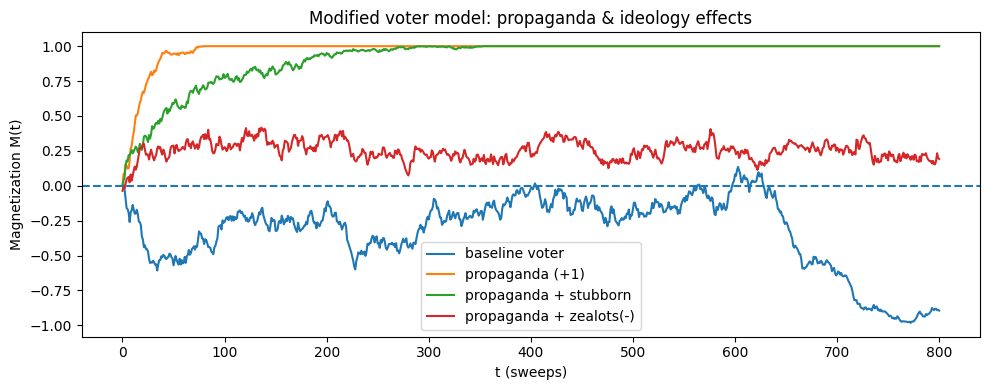

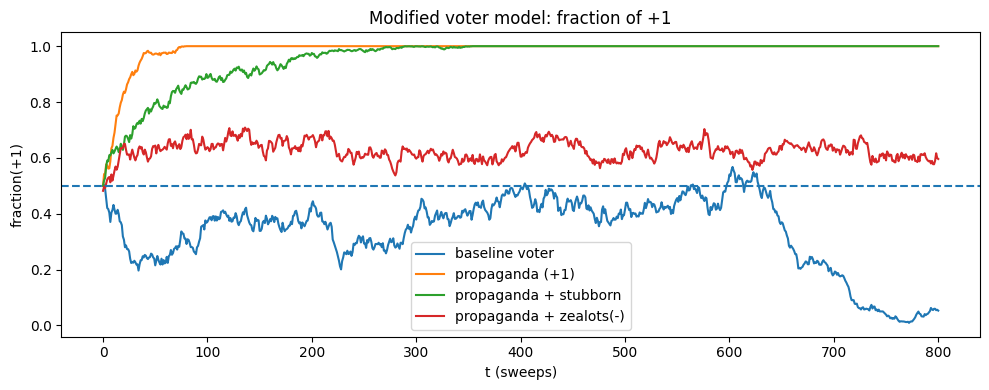

In [22]:
def simulate_voter_with_effects(
    G,
    T=5000,
    init_plus_frac=0.5,
    prop_prob=0.05,
    prop_target=+1,
    stubborn_frac=0.10,
    stubborn_strength=0.90,
    zealot_plus_frac=0.00,
    zealot_minus_frac=0.00,
    update_mode="sweep",
    seed=42,
    return_state=False
):
    rng = np.random.default_rng(seed)

    nodes = list(G.nodes())
    N = len(nodes)
    idx = {u: i for i, u in enumerate(nodes)}
    neigh = [np.fromiter((idx[v] for v in G.neighbors(u)), dtype=int) for u in nodes]

    state = np.full(N, -1, dtype=np.int8)
    n_plus = int(round(init_plus_frac * N))
    if n_plus > 0:
        plus_idx = rng.choice(N, size=n_plus, replace=False)
        state[plus_idx] = 1

    zealot_plus = np.zeros(N, dtype=bool)
    zealot_minus = np.zeros(N, dtype=bool)

    n_zp = int(round(zealot_plus_frac * N))
    n_zm = int(round(zealot_minus_frac * N))
    if n_zp + n_zm > 0:
        all_idx = np.arange(N)
        rng.shuffle(all_idx)
        zp_idx = all_idx[:n_zp]
        zm_idx = all_idx[n_zp:n_zp + n_zm]
        zealot_plus[zp_idx] = True
        zealot_minus[zm_idx] = True
        state[zealot_plus] = 1
        state[zealot_minus] = -1

    fixed = zealot_plus | zealot_minus

    stubborn = np.zeros(N, dtype=bool)
    n_st = int(round(stubborn_frac * N))
    if n_st > 0:
        candidates = np.where(~fixed)[0]
        if candidates.size > 0:
            st_idx = rng.choice(candidates, size=min(n_st, candidates.size), replace=False)
            stubborn[st_idx] = True

    M = np.empty(T + 1, dtype=float)
    frac_plus = np.empty(T + 1, dtype=float)
    M[0] = state.mean()
    frac_plus[0] = (state == 1).mean()

    def is_consensus(x):
        s = int(x.sum())
        return (s == N) or (s == -N)

    t_consensus = 0 if is_consensus(state) else None

    if update_mode not in {"async", "sweep"}:
        raise ValueError("update_mode must be 'async' or 'sweep'")
    if prop_target not in (-1, 1):
        raise ValueError("prop_target must be +1 or -1")

    def one_update():
        i = rng.integers(0, N)
        if fixed[i]:
            return

        if rng.random() < prop_prob:
            proposed = prop_target
        else:
            nb = neigh[i]
            if nb.size == 0:
                return
            j = nb[rng.integers(0, nb.size)]
            proposed = int(state[j])

        if stubborn[i] and proposed != state[i]:
            if rng.random() < stubborn_strength:
                return

        state[i] = proposed

    for t in range(1, T + 1):
        if update_mode == "async":
            one_update()
        else:  # sweep
            for _ in range(N):
                one_update()

        M[t] = state.mean()
        frac_plus[t] = (state == 1).mean()
        if t_consensus is None and is_consensus(state):
            t_consensus = t

    if return_state:
        return M, frac_plus, t_consensus, state, stubborn, fixed
    return M, frac_plus, t_consensus


if __name__ == "__main__":
    N = 2000
    G = nx.erdos_renyi_graph(N, 0.01, seed=1)

    T = 800
    seed = 7

    M0, f0, tC0 = simulate_voter_with_effects(
        G, T=T, seed=seed,
        prop_prob=0.0,
        stubborn_frac=0.0,
        zealot_plus_frac=0.0,
        zealot_minus_frac=0.0,
        update_mode="sweep"
    )

    Mp, fp, tCp = simulate_voter_with_effects(
        G, T=T, seed=seed,
        prop_prob=0.05, prop_target=+1,
        stubborn_frac=0.0,
        update_mode="sweep"
    )

    Mps, fps, tCps = simulate_voter_with_effects(
        G, T=T, seed=seed,
        prop_prob=0.05, prop_target=+1,
        stubborn_frac=0.15, stubborn_strength=0.95,
        update_mode="sweep"
    )

    Mpz, fpz, tCpz = simulate_voter_with_effects(
        G, T=T, seed=seed,
        prop_prob=0.05, prop_target=+1,
        zealot_minus_frac=0.03,
        update_mode="sweep"
    )

    print("Consensus times (in sweeps):")
    print("baseline:", tC0, " propaganda:", tCp, " propaganda+stubborn:", tCps, " propaganda+zealots:", tCpz)

    plt.figure(figsize=(10,4))
    plt.plot(M0, label="baseline voter")
    plt.plot(Mp, label="propaganda (+1)")
    plt.plot(Mps, label="propaganda + stubborn")
    plt.plot(Mpz, label="propaganda + zealots(-)")
    plt.axhline(0.0, linestyle="--")
    plt.xlabel("t (sweeps)")
    plt.ylabel("Magnetization M(t)")
    plt.title("Modified voter model: propaganda & ideology effects")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(f0, label="baseline voter")
    plt.plot(fp, label="propaganda (+1)")
    plt.plot(fps, label="propaganda + stubborn")
    plt.plot(fpz, label="propaganda + zealots(-)")
    plt.axhline(0.5, linestyle="--")
    plt.xlabel("t (sweeps)")
    plt.ylabel("fraction(+1)")
    plt.title("Modified voter model: fraction of +1")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Propaganda (External Influence)

With probability $p$, an agent adopts a fixed opinion imposed by an external source, independently of its neighbors.

## Stubborn Agents (Inertia)

Some agents resist opinion changes and accept a new opinion only with probability $1 - q$, introducing inertia into the dynamics.

## Zealots (Ideological Commitment)

Zealots are agents with fixed opinions that never change, which can block consensus and sustain opinion diversity.
``


zealots - https://arxiv.org/pdf/2103.00506
subborn - https://arxiv.org/pdf/2405.08202

